<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>


# Estimating Price Elasticity of Orange Juice Demand

### Summary of Contents:
1. [Data](#data)
2. [Naive ML Model](#naive)
3. [DML Model](#dml)
4. [Orthoforest Model](#orthoforest)

We applied our technique to Dominick’s dataset, a popular historical dataset of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. (https://www.chicagobooth.edu/research/kilts/datasets/dominicks)

The dataset has 28947 observations, includes the store level, weekly prices and sales of 3 different brands of orange juice over 7 years in Chicago area. The dataset also contains 17 continuous and categorical variables that encode store-level customer information such as the age, log income, education level, etc, as well as brand information. The goal is to learn the elasticity of orange juice as a function of income in the presence of high-dimensional controls.

We define the following variables:

* Y: Orange Juice sales (log)
* T: Price (log)
* X: Income (feature of heterogeneity)
* W: Store-level features (education, age, etc.)
* $\theta(X)$: Effect of price on sales (Orange juice elasticity)

The model can be built as:
$$
\begin{align}
Y & = \theta(X) \cdot T + f(W) + \epsilon\\
T & = g(W) + \eta
\end{align}
$$

In [120]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [121]:
# Main imports
from econml.dml import DMLCateEstimator,SparseLinearDMLCateEstimator
from econml.ortho_forest import ContinuousTreatmentOrthoForest, WeightedModelWrapper

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV,LinearRegression,MultiTaskElasticNet,MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import urllib.request 
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

# 1. Data

In [78]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.blob.core.windows.net/datasets/OrangeJuice/oj_large.csv", file_name)
oj_data = pd.read_csv(file_name)

## 1.1 Data Exploration

In [79]:
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [80]:
oj_data.shape

(28947, 17)

In [81]:
oj_data.dtypes

store         int64
brand        object
week          int64
logmove     float64
feat          int64
price       float64
AGE60       float64
EDUC        float64
ETHNIC      float64
INCOME      float64
HHLARGE     float64
WORKWOM     float64
HVAL150     float64
SSTRDIST    float64
SSTRVOL     float64
CPDIST5     float64
CPWVOL5     float64
dtype: object

In [82]:
oj_data.describe()

,store,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
count,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000,28947.000000
mean,80.883511,100.459944,9.167864,0.237261,2.282488,0.173130,0.225220,0.155557,10.616735,0.115602,0.359178,0.343766,5.097274,1.207317,2.120359,0.438914
std,35.576511,34.692314,1.019378,0.425411,0.648001,0.061872,0.109945,0.187581,0.282314,0.030168,0.052673,0.239028,3.472386,0.526528,0.729828,0.219248
min,2.000000,40.000000,4.158883,0.000000,0.520000,0.058054,0.049550,0.024247,9.867083,0.013506,0.244463,0.002509,0.132097,0.400000,0.772530,0.094562
25%,53.000000,70.000000,8.489616,0.000000,1.790000,0.122100,0.145985,0.041910,10.456079,0.097938,0.312636,0.123486,2.767046,0.727273,1.626192,0.271673
50%,86.000000,101.000000,9.034080,0.000000,2.170000,0.170655,0.229390,0.074656,10.635326,0.111221,0.355635,0.346154,4.650687,1.115385,1.963412,0.383227
75%,111.000000,130.000000,9.764685,0.000000,2.730000,0.213949,0.284395,0.187761,10.796960,0.135168,0.402313,0.528313,6.650602,1.538462,2.533672,0.560240
max,137.000000,160.000000,13.482016,1.000000,3.870000,0.307398,0.528362,0.995691,11.236197,0.216354,0.472308,0.916699,17.855951,2.571429,4.107902,1.143367


Text(0.5, 1.0, 'Elasticity of orange juice with different brands')

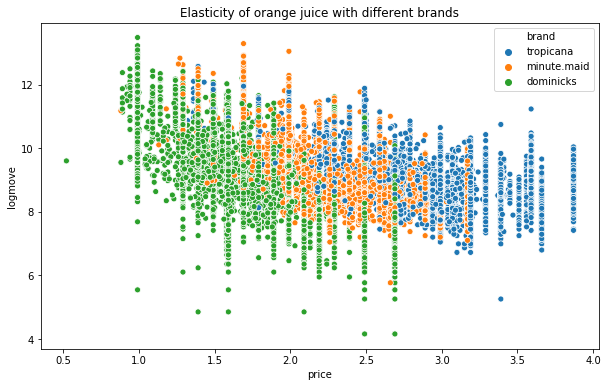

In [83]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x="price", y="logmove",hue="brand", data=oj_data)
plt.title("Elasticity of orange juice with different brands")

Text(0.5, 1.0, 'Elasticity of orange juice with income')

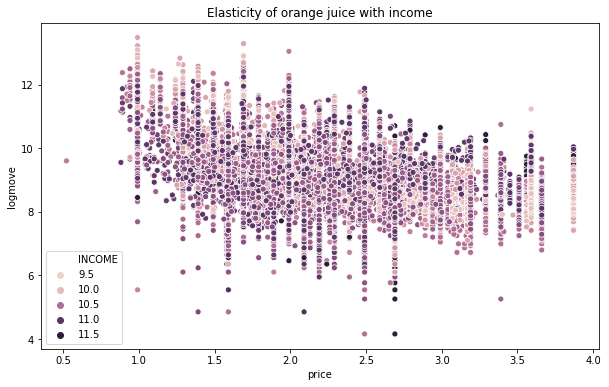

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="price", y="logmove",hue="INCOME", data=oj_data)
plt.title("Elasticity of orange juice with income")

## 1.2 Data Preprocessing

In [86]:
def datapre(data):
    # Prepare data
    Y = data['logmove'].values
    T = np.log(data["price"]).values
    scaler = StandardScaler()
    W1 = scaler.fit_transform(data[[c for c in data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store','INCOME']]].values)
    W2 = pd.get_dummies(data['brand'],drop_first=True).values
    W = np.concatenate([W1, W2], axis=1)
    X=data[['INCOME']].values
    return Y,T,W,X
Y,T,W,X=datapre(oj_data)

In [87]:
## Generate test data
min_income = 10.0 
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

# 2. Naive ML Model

we tried to fit different naive machine learning models to see whether they can capture the reasonable heterogeneous treatment effects on income.

## 2.1 $y = c+\theta(x)\cdot T+\epsilon, \theta(x)=a+b\cdot x$


In [88]:
from econml.utilities import cross_product

In [89]:
Y,T,W,X=datapre(oj_data)
poly = PolynomialFeatures(1,include_bias=True)
XT=cross_product(poly.fit_transform(X),T)

In [90]:
##fit linear model y~XT
import statsmodels.api as sm
XT1= sm.add_constant(XT)
model = sm.OLS(Y, XT1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     3807.
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:39:23   Log-Likelihood:                -38249.
No. Observations:               28947   AIC:                         7.650e+04
Df Residuals:                   28944   BIC:                         7.653e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4243      0.015    678.866      0.000      10.394      10.454
x1            -1.1206      0.234     -4.788      0.000      -1.579      -0.662
x2            -0.0454      0.022     -2.061      0.039      -0.089      -0.002
==============================================================================
Omnibus:                      158.806   Durbin-Watson:                   1.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              232.337
Skew:                          -0.006   Prob(JB):                     3.54e-51
Kurtosis:                       3.439   Cond. No.                         395.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

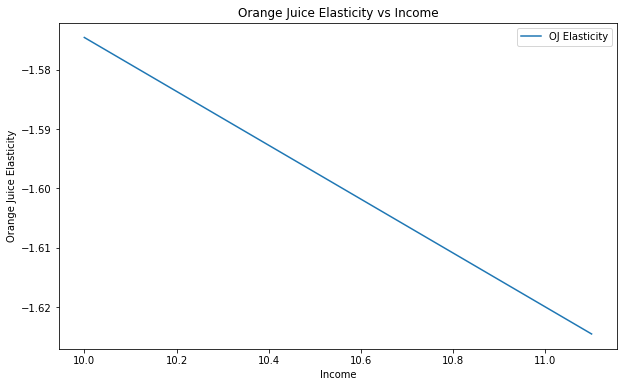

In [91]:
plt.figure(figsize=(10,6))
plt.plot(X_test,model.params[1]+model.params[2]*X_test,label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

## 2.2 $y =c+ \theta(x)\cdot T+ f(W) +\epsilon,  \theta(x)=a+b\cdot x$

In [92]:
Y,T,W,X=datapre(oj_data)
poly = PolynomialFeatures(1,include_bias=True)
XT=cross_product(poly.fit_transform(X),T)
XTW=np.hstack((XT,W))
XTW1= sm.add_constant(XTW)
model = sm.OLS(Y, XTW1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     2525.
Date:                Mon, 03 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:41:19   Log-Likelihood:                -29517.
No. Observations:               28947   AIC:                         5.907e+04
Df Residuals:                   28931   BIC:                         5.920e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5276      0.013    810.941      0.000      10.502      10.553
x1            -6.2772      0.331    -18.954      0.000      -6.926      -5.628
x2             0.3465      0.031     11.101      0.000       0.285       0.408
x3             0.3737      0.004     88.669      0.000       0.365       0.382
x4             0.1009      0.008     12.634      0.000       0.085       0.117
x5             0.0108      0.011      0.998      0.318      -0.010       0.032
x6             0.1889      0.007     28.704      0.000       0.176       0.202
x7            -0.0852      0.007    -12.717      0.000      -0.098      -0.072
x8            -0.0383      0.008     -4.880      0.000      -0.054      -0.023
x9             0.0779      0.010      7.651      0.000       0.058       0.098
x10           -0.0588      0.005    -11.336      0.000      -0.069      -0.049
x11           -0.0154      0.005     -2.948      0.003      -0.026      -0.005
x12            0.0177      0.005      3.871      0.000       0.009       0.027
x13           -0.1199      0.006    -20.877      0.000      -0.131      -0.109
x14            0.6998      0.011     62.660      0.000       0.678       0.722
x15            1.3355      0.014     94.531      0.000       1.308       1.363
==============================================================================
Omnibus:                      955.479   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2550.836
Skew:                          -0.099   Prob(JB):                         0.00
Kurtosis:                       4.441   Cond. No.                         758.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

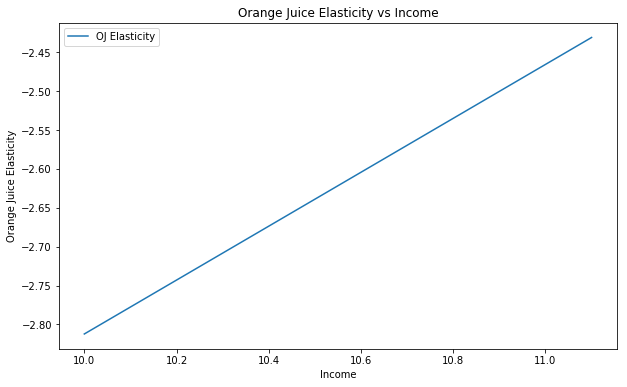

In [93]:
plt.figure(figsize=(10,6))
plt.plot(X_test,model.params[1]+model.params[2]*X_test,label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

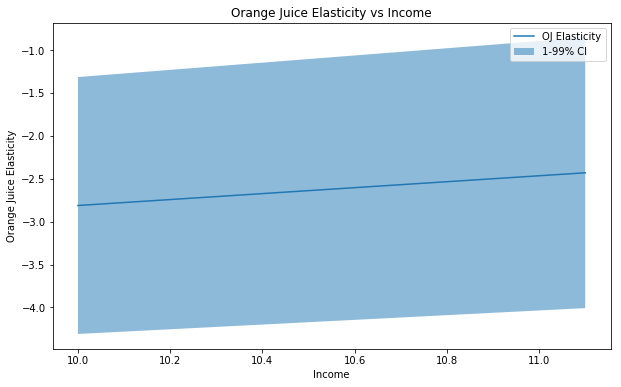

In [94]:
##Confidence Interval from statsmodel attributes
aci=model.conf_int(alpha=0.02, cols=None)[1]
bci=model.conf_int(alpha=0.02, cols=None)[2]
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(),model.params[1]+model.params[2]*X_test,label="OJ Elasticity")
plt.fill_between(X_test.flatten(),aci[0]+bci[0]*X_test.flatten() , aci[1]+bci[1]*X_test.flatten(), alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

In [95]:
###Boostrap confidence interval
def bootstrap(X,Y,n,lower,upper):
    n_samples=X.shape[0]
    param_a=[]
    param_b=[]
    for i in range(n):
        ind=np.random.choice(n_samples,n_samples,replace=True)
        model = sm.OLS(Y[ind], X[ind]).fit()
        param_a.append(model.params[1])
        param_b.append(model.params[2])
    a_lower=np.percentile(param_a,lower)
    a_upper=np.percentile(param_a,upper)
    b_lower=np.percentile(param_b,lower)
    b_upper=np.percentile(param_b,upper)
    return a_lower,a_upper,b_lower,b_upper
        

In [96]:
a_lower,a_upper,b_lower,b_upper=bootstrap(XTW1,Y,20,1,99)

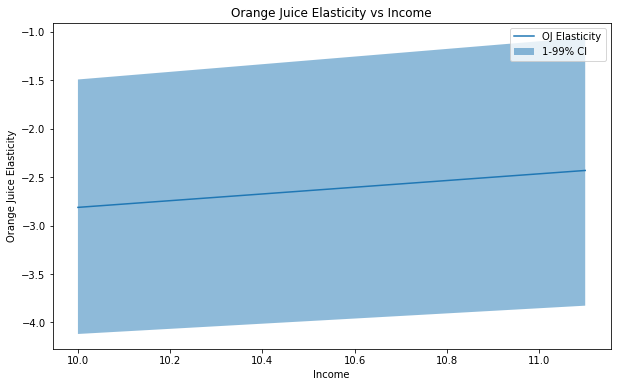

In [97]:
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(),model.params[1]+model.params[2]*X_test,label="OJ Elasticity")
plt.fill_between(X_test.flatten(),a_lower+b_lower*X_test.flatten() , a_upper+b_upper*X_test.flatten(), alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

**Conclusion:**: While full naive model can capture the reasonable heterogeneity, the confidence inveteral is too wide. 

# 3. DML Model

We applied the `DMLCateEstimator` in our EconML package to estimate orange juice price elasticity
as a function of income, and our results, unveil the natural phenomenon that lower income consumers are more price-sensitive.

DML follows the procedures below:
1. Regress $Y$ ~ $W$, learn $\hat{Y}$
2. Regress $T$ ~ $W$, learn $\hat{T}$
3. Linear regression on residuals: $(Y-\hat{Y})$ ~ $(T-\hat{T})\otimes\phi(X)$
4. $\theta(X) = \langle \vec{a},\phi(X) \rangle$ where $\vec{a}$ is the coefficient vector from the final model regression

Note: for $\theta$ constant, $\theta$ is the coefficient from $(Y-\hat{Y})$ ~ $(T-\hat{T})$

## 3.1 Default setting: Linear model as final stage 

In [98]:
Y,T,W,X=datapre(oj_data)

In [99]:
est = DMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor())
est.fit(Y, T, X, W)
te_pred=est.effect(X_test)

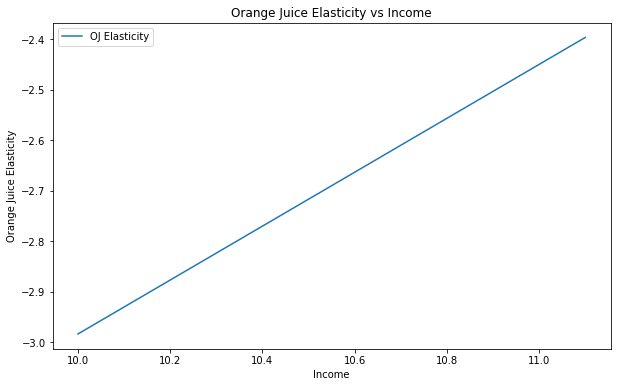

In [100]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

In [101]:
###Boostrap confidence interval
from econml.bootstrap import BootstrapEstimator
boot_est=BootstrapEstimator(DMLCateEstimator(model_y=RandomForestRegressor(),
                                             model_t=RandomForestRegressor()),n_bootstrap_samples=20)
boot_est.fit(Y, T, X, W)
te_pred_interval = boot_est.const_marginal_effect_interval(X_test, lower=1, upper=99)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   20.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


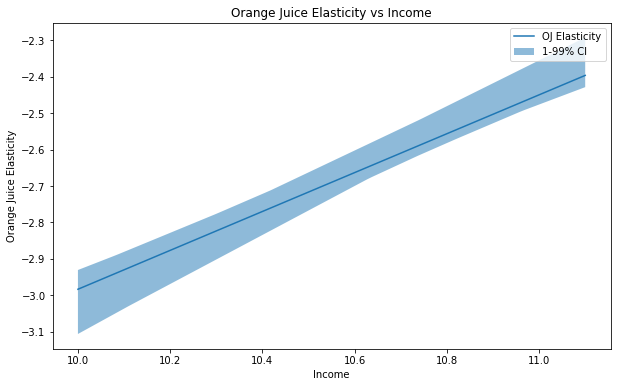

In [102]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## 3.2 Polynomial linear model as  final stage 

In [103]:
Y,T,W,X=datapre(oj_data)

In [104]:
est = DMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor(),featurizer=PolynomialFeatures(degree=3))
est.fit(Y, T, X, W)
te_pred=est.effect(X_test)

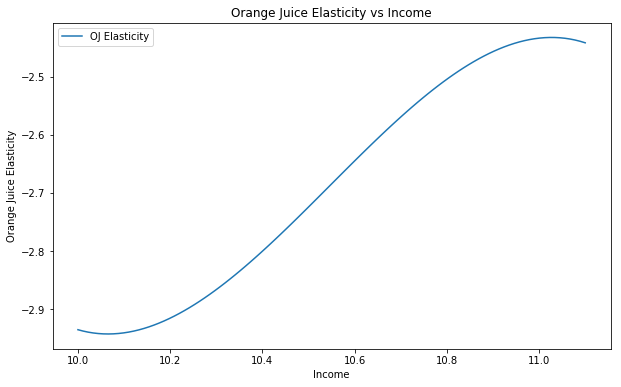

In [105]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

In [106]:
###Boostrap confidence interval
from econml.bootstrap import BootstrapEstimator
boot_est=BootstrapEstimator(DMLCateEstimator(model_y=RandomForestRegressor(),
                                             model_t=RandomForestRegressor(),
                            featurizer=PolynomialFeatures(degree=3)), 
                            n_bootstrap_samples=20)
boot_est.fit(Y, T, X, W)
te_pred_interval = boot_est.const_marginal_effect_interval(X_test, lower=1, upper=99)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   24.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


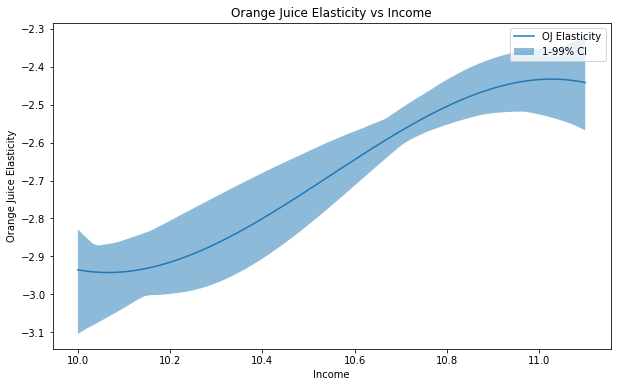

In [107]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(10,6))
plt.plot(X_test.flatten(), te_pred, label="OJ Elasticity")
plt.fill_between(X_test.flatten(), te_pred_interval[0], te_pred_interval[1], alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()

## 3.3 Model Selection

Here we tried different polynomial degrees in our final model to compare the model performance. The score of final model can be seen as the proxy of the score of the treatment effect when we don't know the true treatment effect. We can use this function to do model selection or parameter tuning.

In [108]:
Y,T,W,X=datapre(oj_data)
X_train, X_test, Y_train, Y_test, W_train, W_test, T_train, T_test = train_test_split(X, Y, W, T, test_size=0.3, random_state=42)

In [109]:
# we try degree = [1,2,3,4,5]
score={}
for i in range(1,6):
    est = DMLCateEstimator(model_y=RandomForestRegressor(),model_t=RandomForestRegressor(),featurizer=PolynomialFeatures(degree=i))
    est.fit(Y, T, X, W)
    score['DML polynomial degree={}'.format(i)]=est.score(Y_test, T_test, X_test, W_test)
    

In [110]:
score

{'DML polynomial degree=1': 0.34310486058732903,
 'DML polynomial degree=2': 0.3415244995230724,
 'DML polynomial degree=3': 0.3422950912394541,
 'DML polynomial degree=4': 0.34116220295668886,
 'DML polynomial degree=5': 0.34133333520861125}

In [111]:
print("best model selected by score: ",min(score,key=lambda x: score.get(x)))

best model selected by score:  DML polynomial degree=4


# Try it out!
Build your own models by changing the first stage nuisance estimators or final stage featurizers, comparing the model performance by the score function above.

In [ ]:
##try it out here!

## 3.4 Multiple Continuous Treatment, Multiple Outcome Observational Data

We use the same data, but in this case, we want to fit the demand of multiple brand as a function of the price of each one of them, i.e. fit the matrix of cross price elasticities. It can be done, by simply setting as $Y$ to be the vector of demands and $T$ to be the vector of prices. Then we can obtain the matrix of cross price elasticities.

\begin{align}
Y=[Logmove_{tropicana},Logmove_{minute.maid},Logmove_{dominicks}] \\
T=[Logprice_{tropicana},Logprice_{minute.maid},Logprice_{dominicks}] \\
\end{align}


In [112]:
# Import the data
oj_data = pd.read_csv(file_name)

In [113]:
# Prepare data
oj_data['price']=np.log(oj_data["price"])
# Transform dataset. 
# For each store in each week, get a vector of logmove and a vector of logprice for each brand. 
# Other features are store specific, will be the same for all brands.
groupbylist=["store","week","AGE60","EDUC","ETHNIC","INCOME","HHLARGE","WORKWOM","HVAL150",
             "SSTRDIST","SSTRVOL","CPDIST5","CPWVOL5"]
oj_data1=pd.pivot_table(oj_data,index=groupbylist,columns=oj_data.groupby(groupbylist).cumcount(),
                        values=['logmove','price'],aggfunc='sum').reset_index()
oj_data1.columns=oj_data1.columns.map('{0[0]}{0[1]}'.format) 
oj_data1=oj_data1.rename(index=str,columns={"logmove0": "logmove_T", "logmove1": "logmove_M",
                                            "logmove2":"logmove_D","price0":"price_T","price1":"price_M","price2":"price_D"})

# Define Y,T,X,W
Y = oj_data1[['logmove_T',"logmove_M","logmove_D"]].values
T=oj_data1[['price_T',"price_M","price_D"]].values
scaler = StandardScaler()
W=scaler.fit_transform(oj_data1[[c for c in groupbylist if c not in ['week', 'store','INCOME']]].values)
X=oj_data1[['INCOME']].values

In [114]:
## Generate test data
min_income = 10.0 
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

In [115]:
est = DMLCateEstimator(model_y=MultiTaskElasticNetCV(cv=3),model_t=MultiTaskElasticNetCV(cv=3))
est.fit(Y, T, X, W)
te_pred=est.const_marginal_effect(X_test)

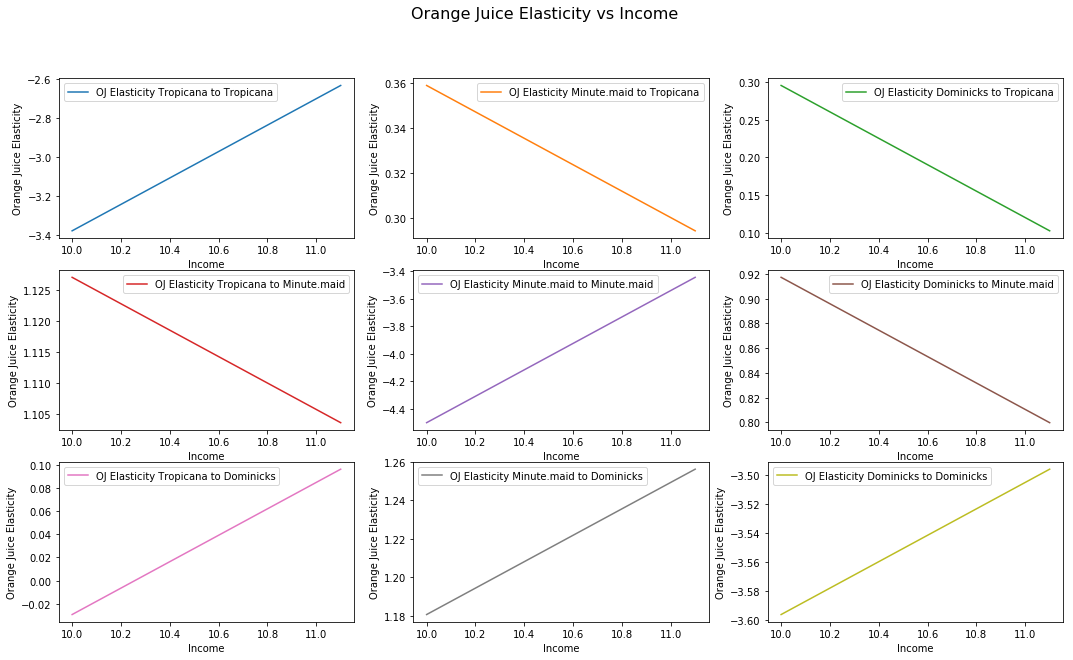

In [116]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18,10))
dic={0:"Tropicana",1:"Minute.maid",2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, 3*i+j+1)
        plt.plot(X_test, te_pred[:,i,j],color="C{}".format(str(3*i+j)),label="OJ Elasticity {} to {}".format(dic[j],dic[i]))
        plt.xlabel(r'Income')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income",fontsize=16)
plt.show()

**Findings**: Look at the diagonal of the matrix, the TE of OJ prices are always negative to the sales across all the brand, but people with higher income are less price-sensitive. By contrast, for the non-diagonal of the matrix, the TE of prices for other brands are always positive to the sales for that brand, the TE is affected by income in different ways for different competitors. In addition, compare to previous plot, the negative TE of OJ prices for each brand are all larger than the TE considering all brand together, which means we would have underestimated the effect of price changes on demand. 

In [117]:
from econml.bootstrap import BootstrapEstimator
boot_est=BootstrapEstimator(DMLCateEstimator(model_y=MultiTaskElasticNetCV(cv=3),model_t=MultiTaskElasticNetCV(cv=3))
                            ,n_bootstrap_samples=20)
boot_est.fit(Y,T,X,W)
te_pred_interval = boot_est.const_marginal_effect_interval(X_test, lower=1, upper=99)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


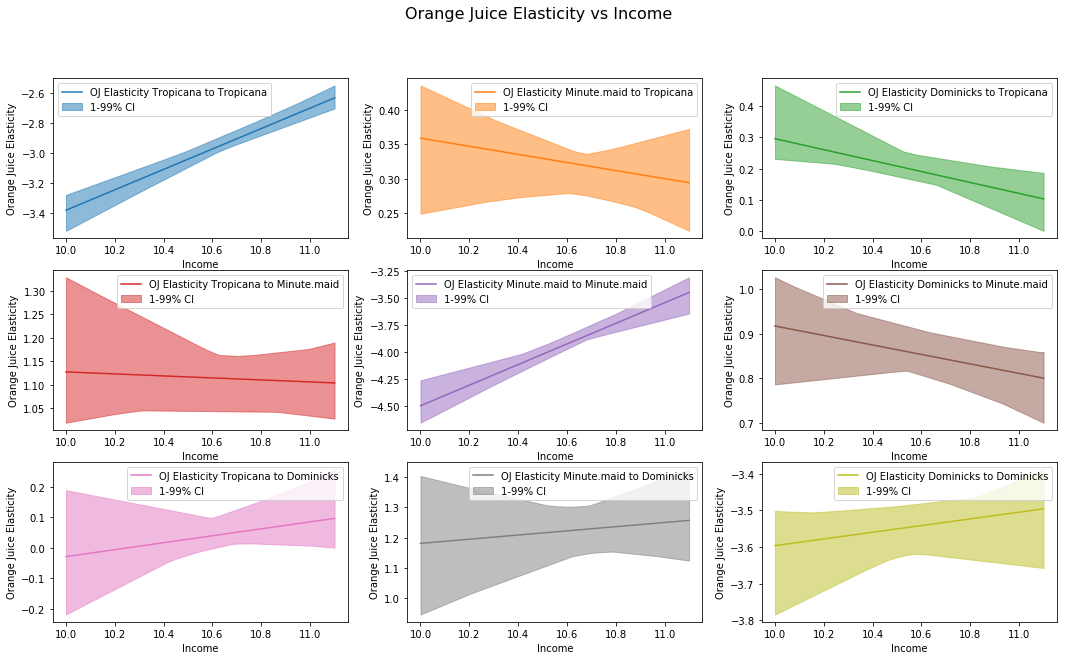

In [118]:
# Plot Oranje Juice elasticity as a function of income
plt.figure(figsize=(18,10))
dic={0:"Tropicana",1:"Minute.maid",2:"Dominicks"}
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, 3*i+j+1)
        plt.plot(X_test, te_pred[:,i,j],color="C{}".format(str(3*i+j)),label="OJ Elasticity {} to {}".format(dic[j],dic[i]))
        plt.fill_between(X_test.flatten(), te_pred_interval[0][:, i, j],te_pred_interval[1][:, i,j], color="C{}".format(str(3*i+j)),alpha=.5, label="1-99% CI")
        plt.xlabel(r'Income')
        plt.ylabel('Orange Juice Elasticity')
        plt.legend()
plt.suptitle("Orange Juice Elasticity vs Income",fontsize=16)
plt.show()

**Note**: For expository purpose, we only run 20 samples here to get the Confidence Interval. More samples are needed for validity of the bootstrap. 

# 4. OrthoForest Model

We applied the `ContinuousTreatmentOrthoForest` in EconML package to estimate orange juice price elasticity
as a function of income, and our results showed the similar result with DML that lower income consumers are more price-sensitive.

In [64]:
# Import the data
oj_data = pd.read_csv(file_name)
Y,T,W,X=datapre(oj_data)

In [65]:
# Define some parameters
n_trees = 2000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.02
bootstrap = False

In [66]:
est = ContinuousTreatmentOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, bootstrap=bootstrap, 
        model_T=Lasso(alpha=0.1),
        model_Y=Lasso(alpha=0.1),
        model_T_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted"), 
        model_Y_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted")
       )

In [67]:
est.fit(Y, T, X, W)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   41.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    4.8s finished


In [68]:
min_income = 10.0 
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

In [69]:
te_pred = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed:  5.6min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  90 out of 101 | elapsed:  6.7min remaining:   49.4s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  6.8min finished


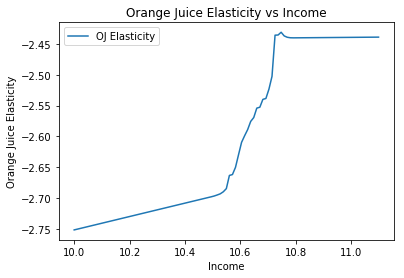

In [70]:
# Plot Oranje Juice elasticity as a function of income
plt.plot(np.ndarray.flatten(X_test), te_pred[:, 0], label="OJ Elasticity")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income")
plt.show()

**Note:** We can also use a bootstrap estimator to generate confidence intervals; in order to return results in a few minutes we're limiting the number of trees to 100 and the number of bootstrap samples to 10 in the code below, but for better estimates these numbers can be increased at the cost of increased runtime.

In [71]:
from econml.bootstrap import BootstrapEstimator
boot_est = BootstrapEstimator(ContinuousTreatmentOrthoForest(
        n_trees=100, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, bootstrap=bootstrap, 
        model_T=Lasso(alpha=0.1),
        model_Y=Lasso(alpha=0.1),
        model_T_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted"), 
        model_Y_final=WeightedModelWrapper(LassoCV(cv=3), sample_type="weighted")
       ), n_bootstrap_samples=10, n_jobs=-1)

In [72]:
boot_est.fit(Y, T, X, W)
te_pred_interval = boot_est.const_marginal_effect_interval(X_test, lower=1, upper=99)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 task

[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed: 16.4min remaining: 13.1min
[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed: 16.4min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed: 16.4min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed: 16.4min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed: 16.5min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed: 16.5min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed: 16.5min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  56 out of 101 | elapsed: 16.5min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  90 out of 101 | elapsed: 19.8min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of 101 | elapsed: 19.8min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of 101 | elapsed: 19.8min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of 101 | elapsed: 19.8min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done 

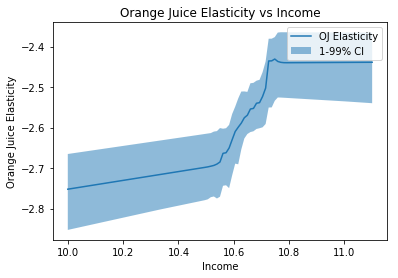

In [73]:
plt.plot(np.ndarray.flatten(X_test), te_pred[:, 0], label="OJ Elasticity")
plt.fill_between(np.ndarray.flatten(X_test), 
                 te_pred_interval[0][:, 0], 
                 te_pred_interval[1][:, 0], alpha=.5, label="1-99% CI")
plt.xlabel(r'Income')
plt.ylabel('Orange Juice Elasticity')
plt.title("Orange Juice Elasticity vs Income")
plt.legend()
plt.show()